In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import pandas as pd

plt.rcParams["figure.dpi"] = 300  # Raise figure quality.

# Areas Covered

- https://en.wikipedia.org/wiki/Valle_del_Cauca_Department
  - 4,532,152
- https://en.wikipedia.org/wiki/Nari%C3%B1o_Department
  - 1,627,589
- https://en.wikipedia.org/wiki/Putumayo_department
  - 359,127
- Total: 6,518,868 

Rough Mission Area: 3,000,000

In [18]:
def model_unsdb(params, y0, ts):
    α, β, γ, δ, ε, ζ, η = params

    def unsdb(t, y):
        # Unconctacted, New People, Sacrament Attendance, Date, Baptized
        U, N, S, D, B = y
        return np.array(
            [
                η * N - α * B * U,  # U'
                α * B * U + ζ * S - (β + η) * N,  # N'
                β * N + ε * D - (δ + ζ) * S,  # S'
                γ * S - (δ + ε) * D,  # D'
                δ * D,  # B'
            ]
        )

    # Solve
    sol = solve_ivp(unsdb, (0, ts[-1]), y0, t_eval=ts)
    if not sol.success:
        return np.zeros((len(y0), len(ts)))
    return sol.y

In [19]:
labels = ["Uncontacted", "New People", "Sacrament", "Date", "Baptized"]


def plot_solutions_separate(ts, y_hat, population, title="Modeled Data"):
    fig, axes = plt.subplots(5, figsize=(4, 6), gridspec_kw={"wspace": 0.5})

    for ax, label, i in zip(axes, labels, range(len(labels))):
        ax.plot(ts / 52, y_hat[i] * population)
        ax.ticklabel_format(style="plain", useOffset=False)
        ax.annotate(
            label,
            xy=(1, 0.5),
            xycoords="axes fraction",
            xytext=(10, 0),
            textcoords="offset points",
            ha="left",
            va="center",
            fontsize=10,
        )  # Adjust text position
        if ax != axes[-1]:  # Check if it's not the bottom subplot
            ax.label_outer()  # Hide x-axis labels and ticks
    plt.tight_layout()
    plt.suptitle(title)


def plot_solutions_together(ts, y_hat, population, title="Modeled Data"):
    for i, label in enumerate(labels):
        if label == "Uncontacted":
            continue
        plt.plot(ts / 52, y_hat[i] * population, label=label)
    plt.title(title)
    plt.xlabel("Time (years)")
    plt.ylabel("People")
    plt.legend()
    plt.ticklabel_format(style="plain", useOffset=False)

/var/folders/1h/k77g_wnj4rl0h5jz__9cgyl80000gn/T/ipykernel_93823/1603550079.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


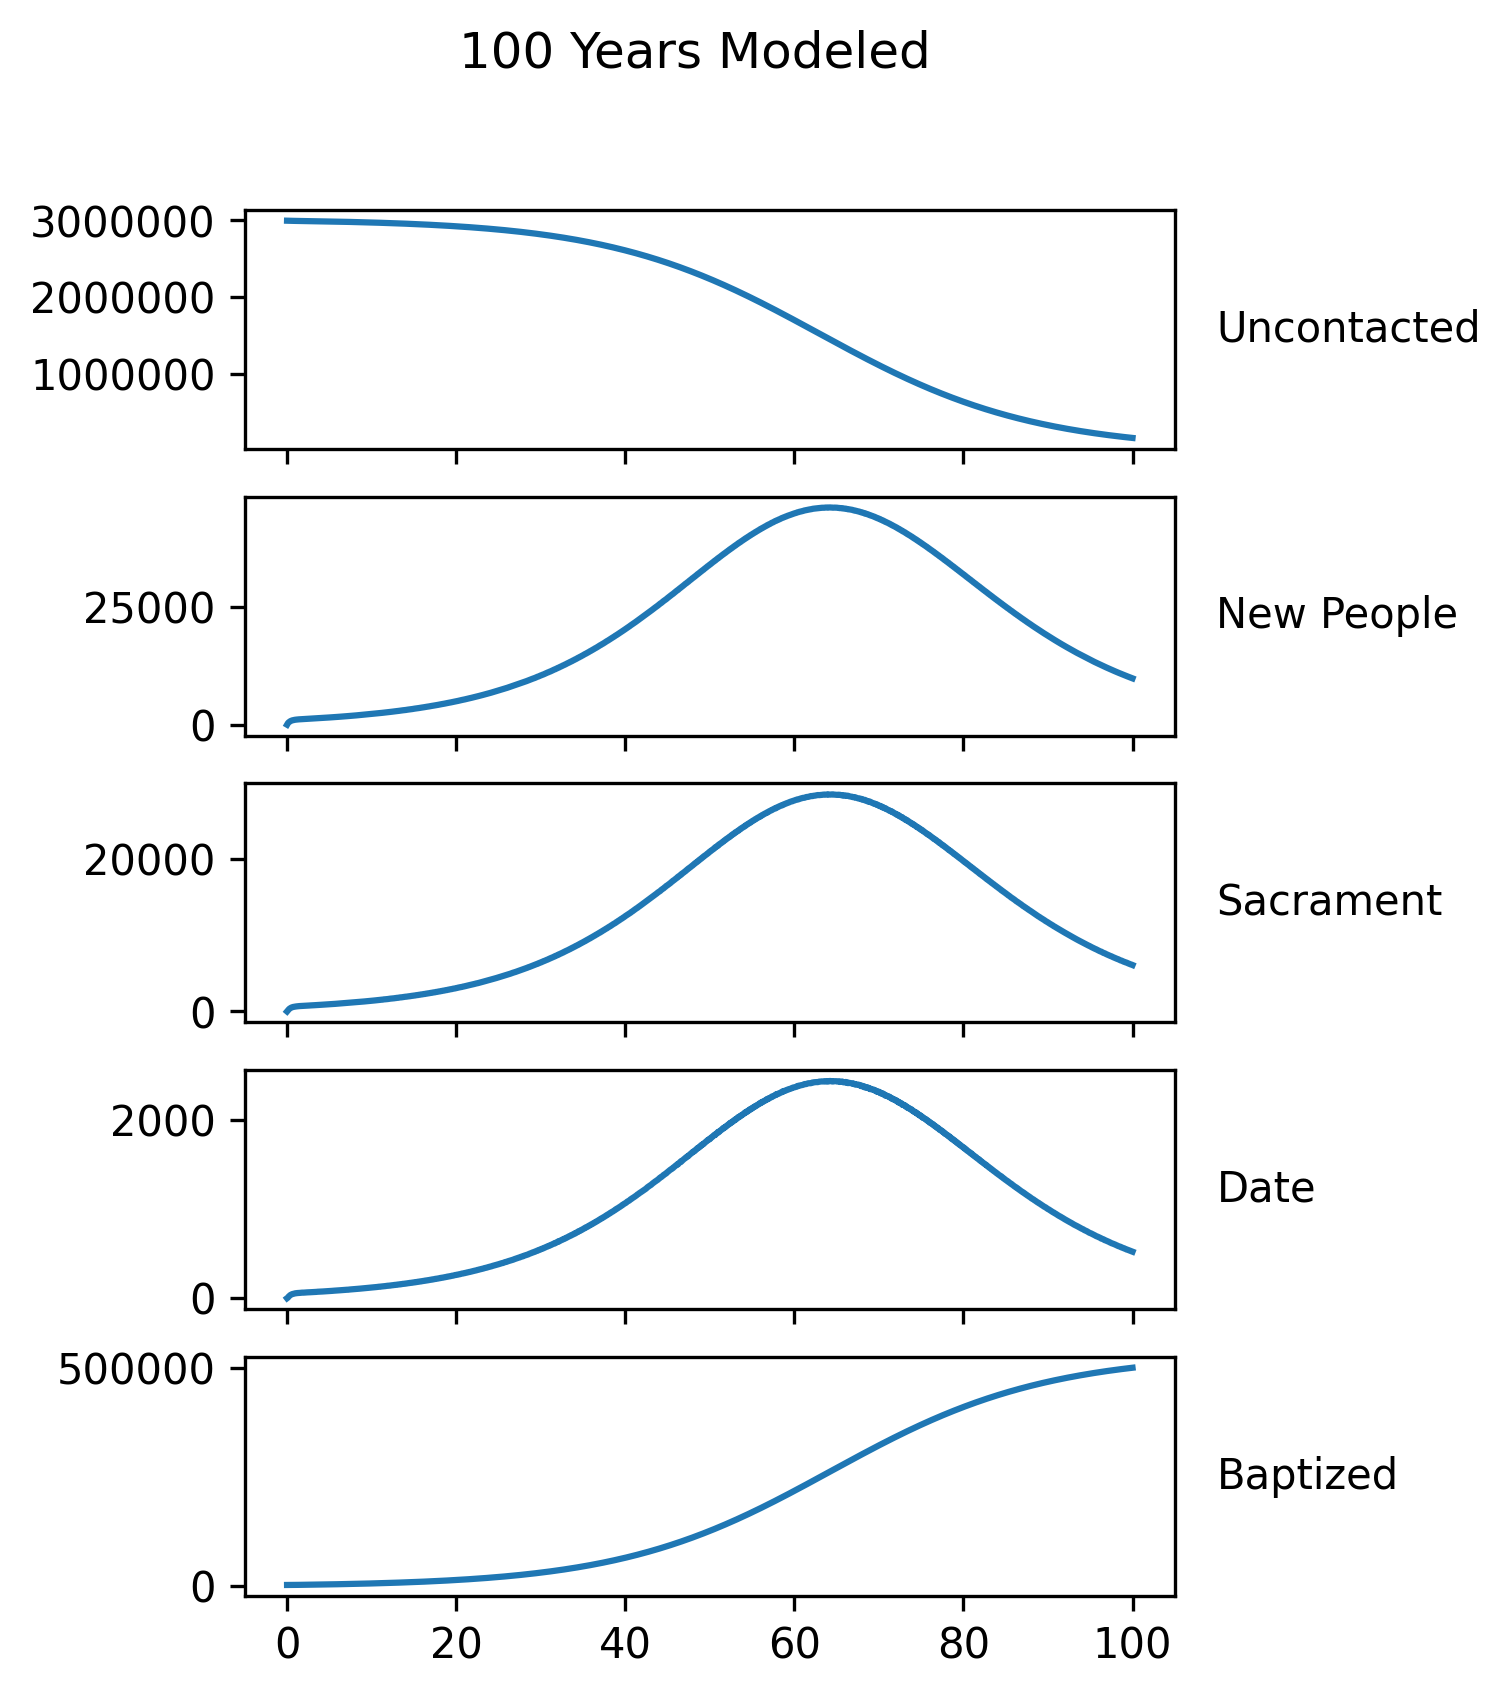

In [20]:
init_members = 5 * 4 * 150
population = 3_000_000
init_U = population - init_members
α = (100 * population) / (init_U * init_members)  # Rate going from Date to Baptized
β = 1 / 3  # Rate going from New People to Sacrament
γ = 1 / 20  # Rate going from Sacrament to Date
δ = 1 / 12  # Rate going from Date to Baptized
ε = 1 / 2  # Rate going from Date to Sacrament
ζ = 1 / 2  # Rate going from Sacrament to Teaching
η = 1 / 15  # Rate going from Teaching to Uncontacted

params = (α, β, γ, δ, ε, ζ, η)

t0 = 0
tf = 52 * 100
ts = np.linspace(t0, tf, 1000)

y0 = np.array([init_U / population, 0, 0, 0, init_members / population])
y_hat = model_unsdb(params, y0, ts)
plot_solutions_separate(ts, y_hat, population, "100 Years Modeled")

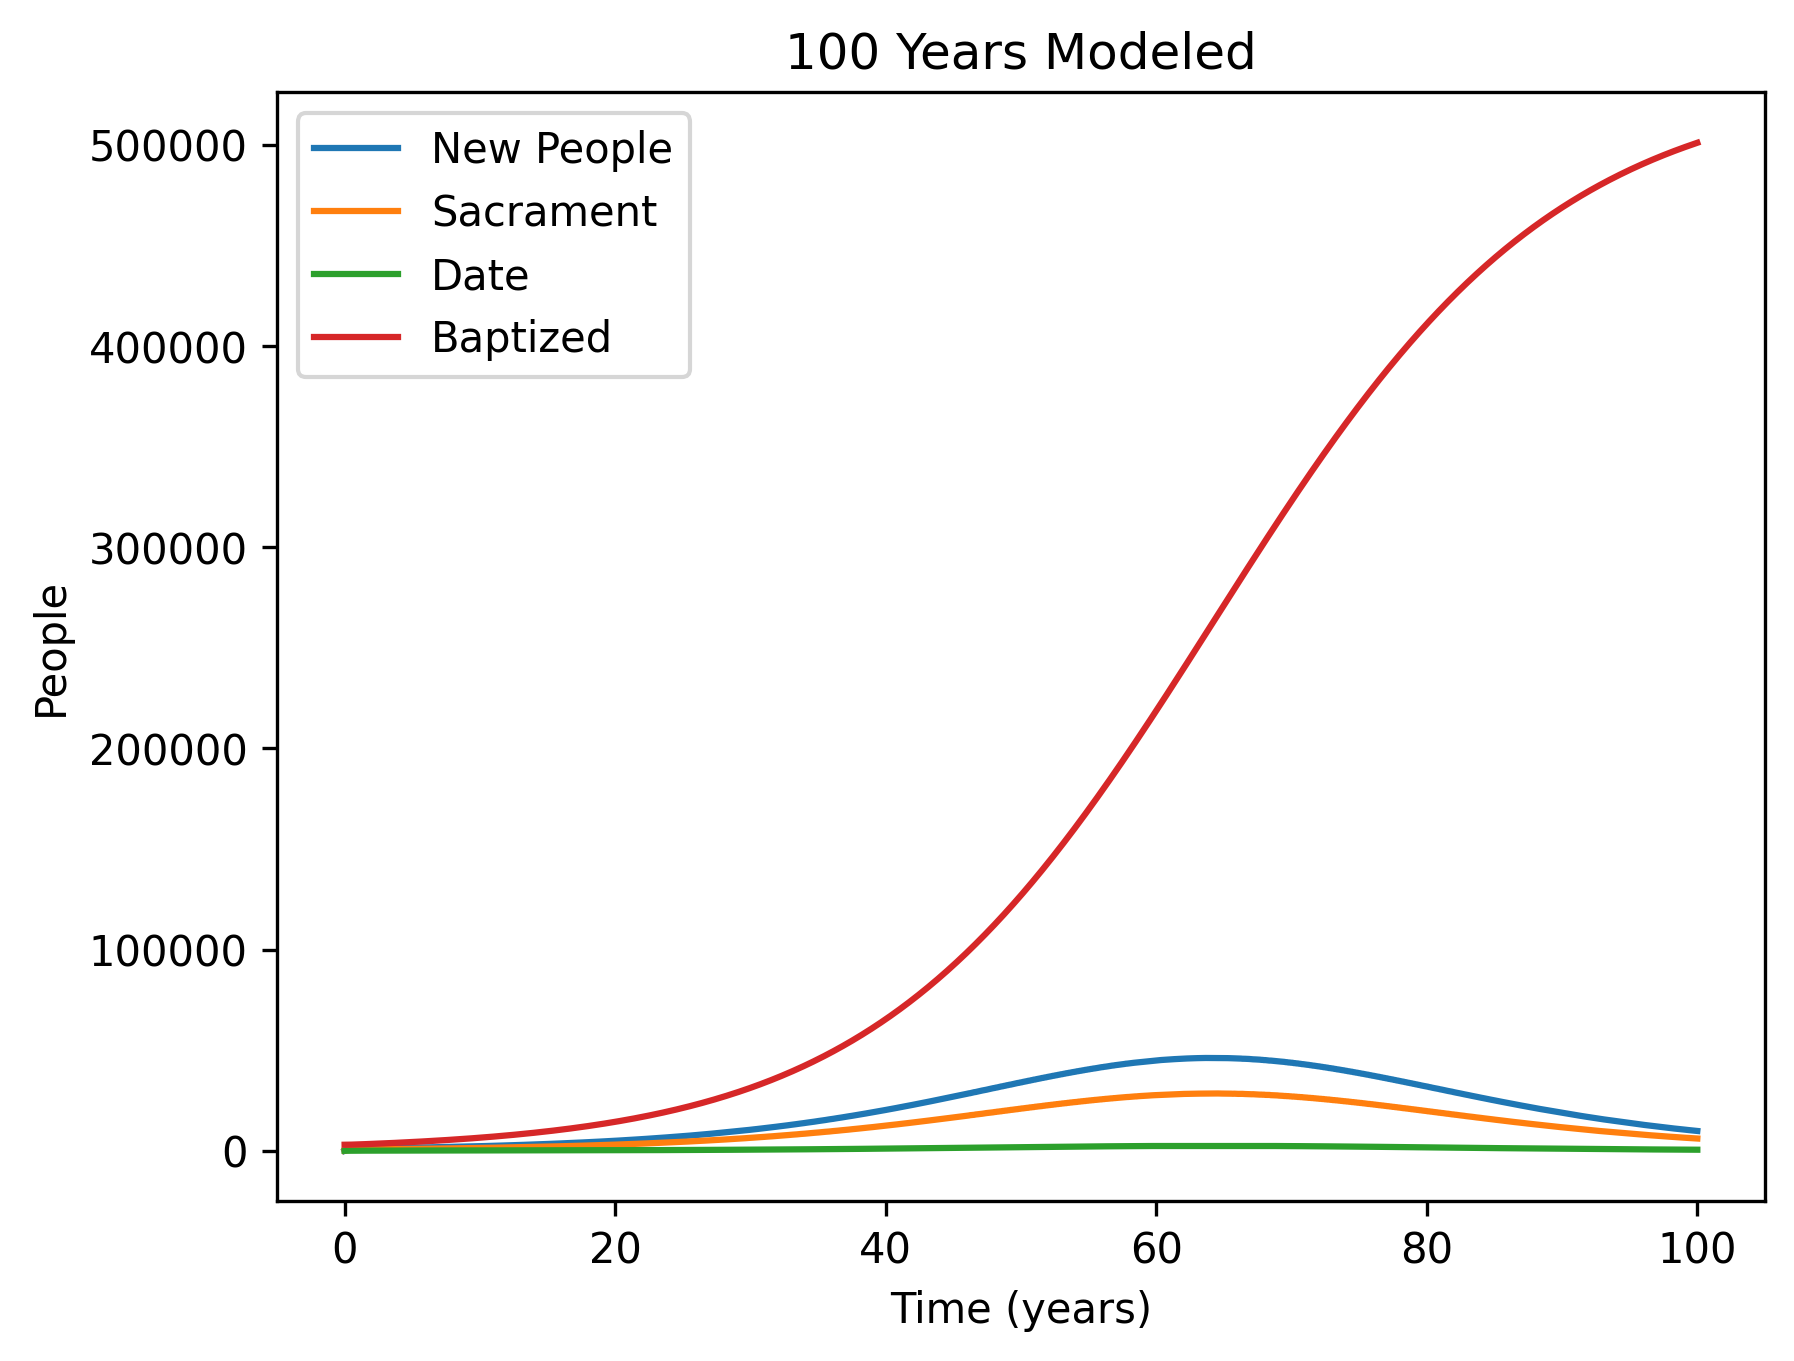

In [21]:
plot_solutions_together(ts, y_hat, population, "100 Years Modeled")

In [22]:
colombia = pd.read_csv("colombia.csv").to_numpy().T / population
ts = np.arange(0, len(colombia[0]))

In [23]:
def error(params):
    ts = np.arange(0, len(colombia[0]))
    y_hat = model_unsdb(params, colombia[:, 0], ts)
    return np.mean(np.linalg.norm(y_hat - colombia, axis=0))
fit = minimize(error, params, options={"disp": True})
y_hat = model_unsdb(fit.x, colombia[:, 0], ts)

Optimization terminated successfully.
         Current function value: 0.000262
         Iterations: 59
         Function evaluations: 616
         Gradient evaluations: 77


/var/folders/1h/k77g_wnj4rl0h5jz__9cgyl80000gn/T/ipykernel_93823/1603550079.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


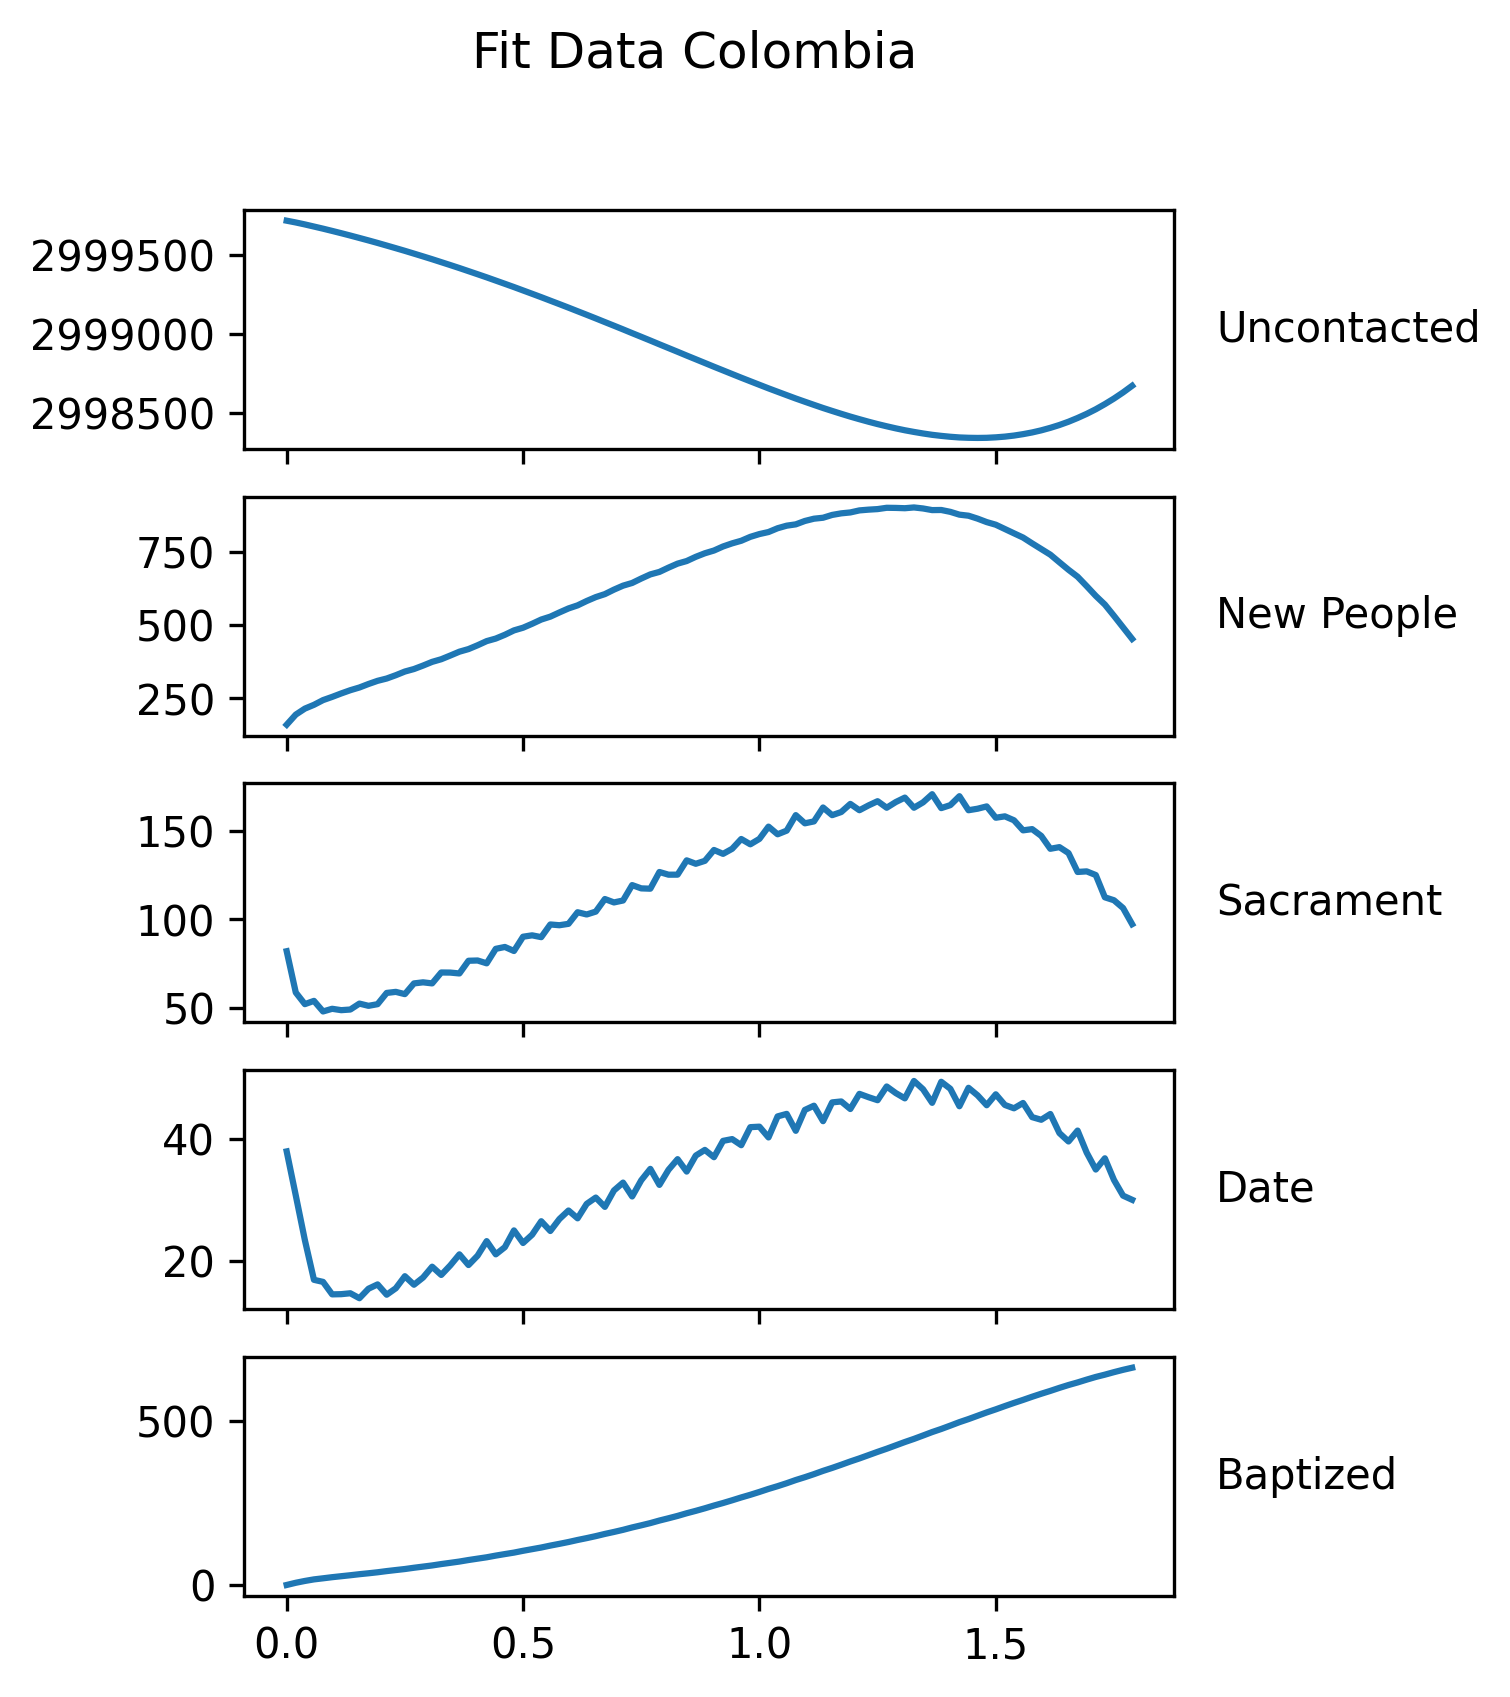

In [24]:
plot_solutions_separate(ts, y_hat, population, "Fit Data Colombia")

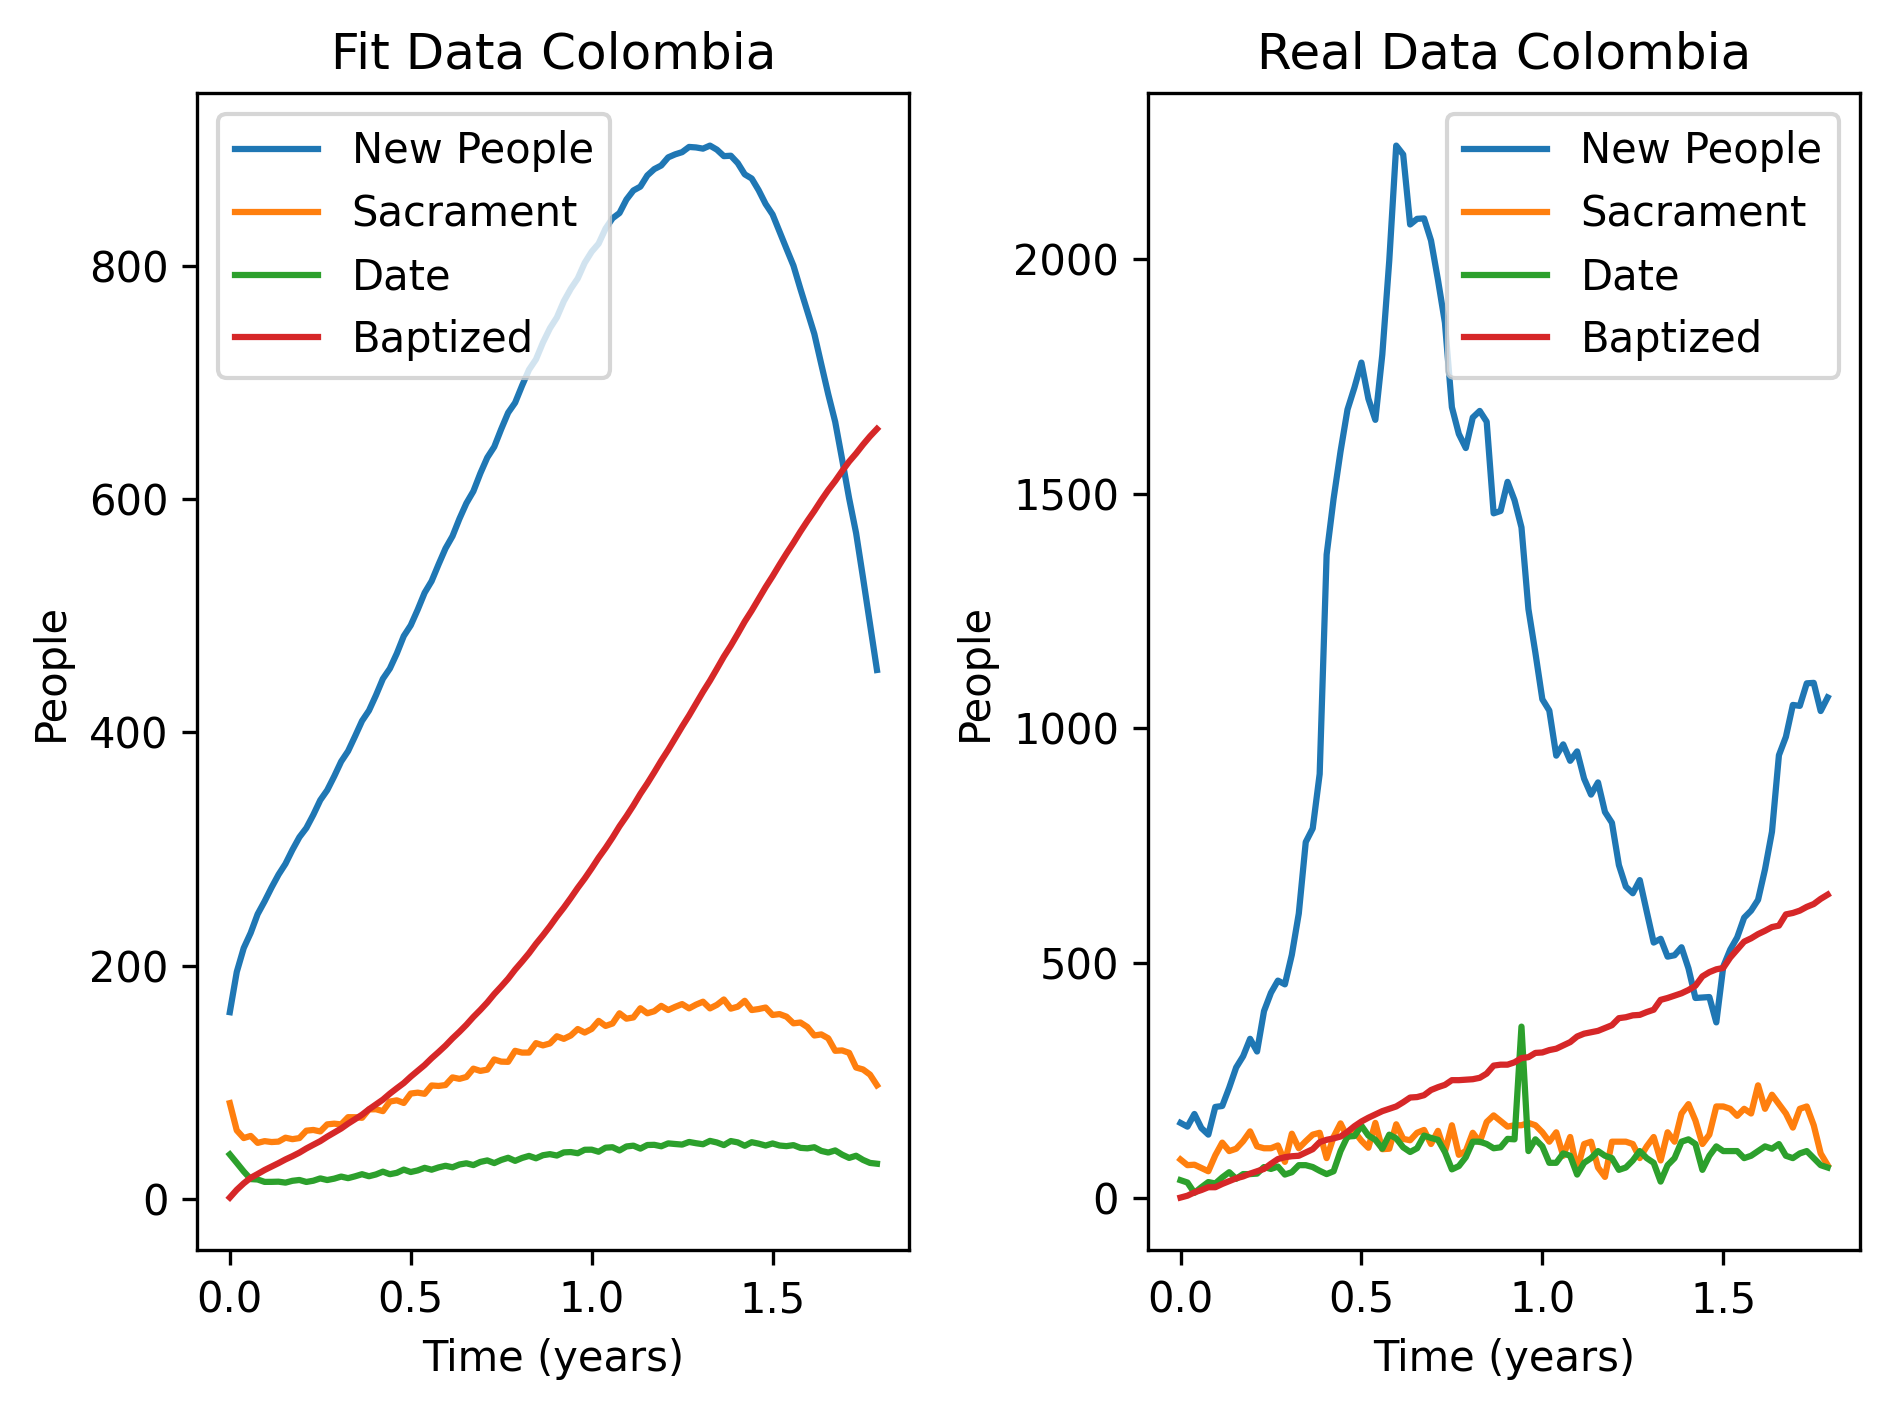

In [26]:
plt.subplot(1, 2, 1)
plot_solutions_together(ts, y_hat, population, "Fit Data Colombia")
plt.subplot(1, 2, 2)
plot_solutions_together(ts, colombia, population, "Real Data Colombia")
plt.tight_layout()
plt.show()